### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/LECTURE5/"

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1D63qmOaEZd-sHv1Fjgvp6pnBKBzUNTIN/2023_Bocconi_20600/Colab/Lez_12


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

### Load, inspect and process data

In [ ]:
unzip = False
if unzip:
    !unzip 'sea_lions_patches.zip'

In [ ]:
def load_images_from_folder(folder):
    images = []
    images_resized = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))

        # Convert to float32 from int32
        img = (img/255).astype(np.float32)

        # Convert from BGR to RGB
        img = img[...,::-1]

        """
        This time the images have already a shape equal to (96,96,3)
        so we will not make square cuttings nor resizing them
        """
        # Make the image dataset squared
        # dim = min(img.shape[:-1])
        # img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2,(img.shape[1]-dim)//2:(img.shape[1]+dim)//2,:]

        # Resize from HxW to 224x224
        # img = tfkl.Resizing(224,224)(img)

        if img is not None:
            images.append(img)

    # convert to np array before returning the data
    return np.array(images)

In [ ]:
!ls train

adult_females  adult_males  backgrounds  juveniles  pups  subadult_males


In [ ]:
!ls train/adult_females

0.png	 14.png   19.png   249.png  299.png  348.png  398.png  447.png	497.png  546.png  596.png
100.png  150.png  1.png    24.png   29.png   349.png  399.png  448.png	498.png  547.png  597.png
101.png  151.png  200.png  250.png  2.png    34.png   39.png   449.png	499.png  548.png  598.png
102.png  152.png  201.png  251.png  300.png  350.png  3.png    44.png	49.png	 549.png  599.png
103.png  153.png  202.png  252.png  301.png  351.png  400.png  450.png	4.png	 54.png   59.png
104.png  154.png  203.png  253.png  302.png  352.png  401.png  451.png	500.png  550.png  5.png
105.png  155.png  204.png  254.png  303.png  353.png  402.png  452.png	501.png  551.png  60.png
106.png  156.png  205.png  255.png  304.png  354.png  403.png  453.png	502.png  552.png  61.png
107.png  157.png  206.png  256.png  305.png  355.png  404.png  454.png	503.png  553.png  62.png
108.png  158.png  207.png  257.png  306.png  356.png  405.png  455.png	504.png  554.png  63.png
109.png  159.png  208.png  258.png  307.png

In [ ]:
# Define the classes in the dataset
classes = ['adult_females', 'adult_males', 'backgrounds', 'juveniles', 'pups', 'subadult_males']

def prepare_classification_dataset(classes):
    # Initialize empty lists for training, validation, and test sets along with their corresponding labels
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    # Iterate through each class in the dataset
    for i, class_name in enumerate(classes):
        # Load images from the train folder
        train_folder = os.path.join('train', class_name)
        train_images = load_images_from_folder(train_folder)
        X_train.extend(train_images)
        y_train.extend([i]*len(train_images))

        # Load images from the validation folder
        val_folder = os.path.join('valid', class_name)
        val_images = load_images_from_folder(val_folder)
        X_val.extend(val_images)
        y_val.extend([i]*len(val_images))

        # Load images from the test folder
        test_folder = os.path.join('test', class_name)
        test_images = load_images_from_folder(test_folder)
        X_test.extend(test_images)
        y_test.extend([i]*len(test_images))

    # Convert the lists to np arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Return the training, validation, and test sets along with their corresponding labels
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_classification_dataset(classes)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(3600, 96, 96, 3) (3600,) (1200, 96, 96, 3) (1200,) (1200, 96, 96, 3) (1200,)


In [ ]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape,y_val.shape,y_test.shape)

(3600, 6) (1200, 6) (1200, 6)


In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_val.shape[1]
batch_size = 64
epochs = 1000
print(f"Input shape: {input_shape}\nOutput shape: {output_shape}\nBatch size: {batch_size}\nEpochs: {epochs}")

Input shape: (96, 96, 3)
Output shape: 6
Batch size: 64
Epochs: 1000


### Build a canonical CNN

Model: "CanonicalCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 24, 24, 128)      

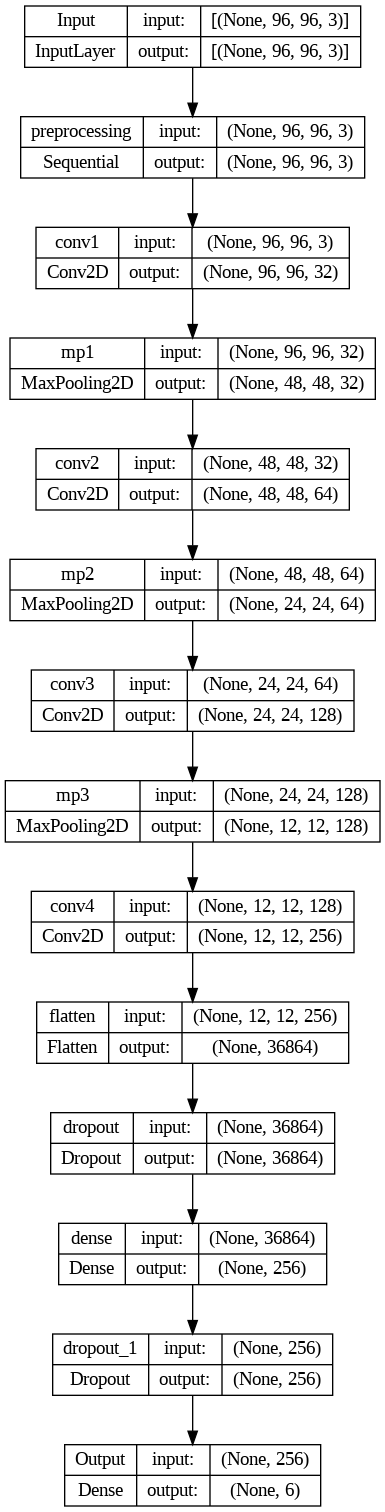

In [ ]:
def build_canonical_cnn(input_shape, output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(),
        tfkl.RandomRotation(0.125)
    ], name='preprocessing')

    x = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='conv1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv4')(x)

    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dropout(0.5)(x)

    x = tfkl.Dense(units=256, activation='relu', name='dense')(x)

    x = tfkl.Dropout(0.5)(x)

    output_layer = tfkl.Dense(units=output_shape, activation='softmax', name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CanonicalCNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

    # Return the model
    return model

canonical_cnn = build_canonical_cnn(input_shape,output_shape)
canonical_cnn.summary()
tfk.utils.plot_model(canonical_cnn, show_shapes=True)

In [ ]:
patience = 20
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience)
scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=patience-3, factor=0.1, min_lr=1e-5)

# Train the model
history = canonical_cnn.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [early_stopping, scheduler]
).history
canonical_cnn.save('canonical_cnn')

Epoch 1/1000
57/57 [==============================] - 16s 51ms/step - loss: 1.7145 - accuracy: 0.2731 - val_loss: 1.5790 - val_accuracy: 0.3483 - lr: 1.0000e-04
Epoch 2/1000
57/57 [==============================] - 2s 30ms/step - loss: 1.3924 - accuracy: 0.4356 - val_loss: 1.4862 - val_accuracy: 0.3542 - lr: 1.0000e-04
Epoch 3/1000
57/57 [==============================] - 2s 31ms/step - loss: 1.1991 - accuracy: 0.5106 - val_loss: 1.3671 - val_accuracy: 0.3992 - lr: 1.0000e-04
Epoch 4/1000
57/57 [==============================] - 2s 30ms/step - loss: 1.1222 - accuracy: 0.5456 - val_loss: 1.3023 - val_accuracy: 0.4725 - lr: 1.0000e-04
Epoch 5/1000
57/57 [==============================] - 2s 32ms/step - loss: 1.0478 - accuracy: 0.5767 - val_loss: 1.3087 - val_accuracy: 0.4358 - lr: 1.0000e-04
Epoch 6/1000
57/57 [==============================] - 2s 32ms/step - loss: 1.0191 - accuracy: 0.5953 - val_loss: 1.3222 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/1000
57/57 [===================

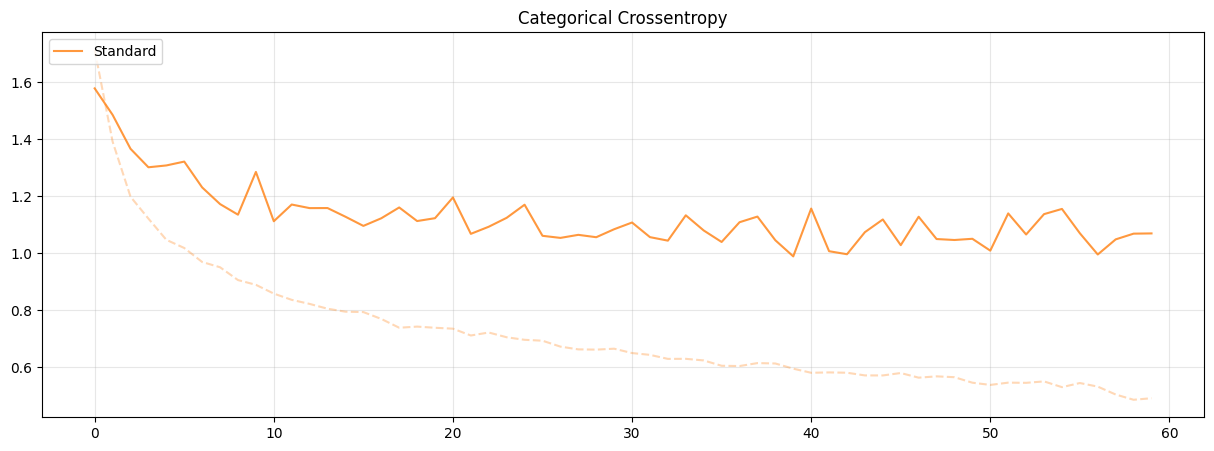

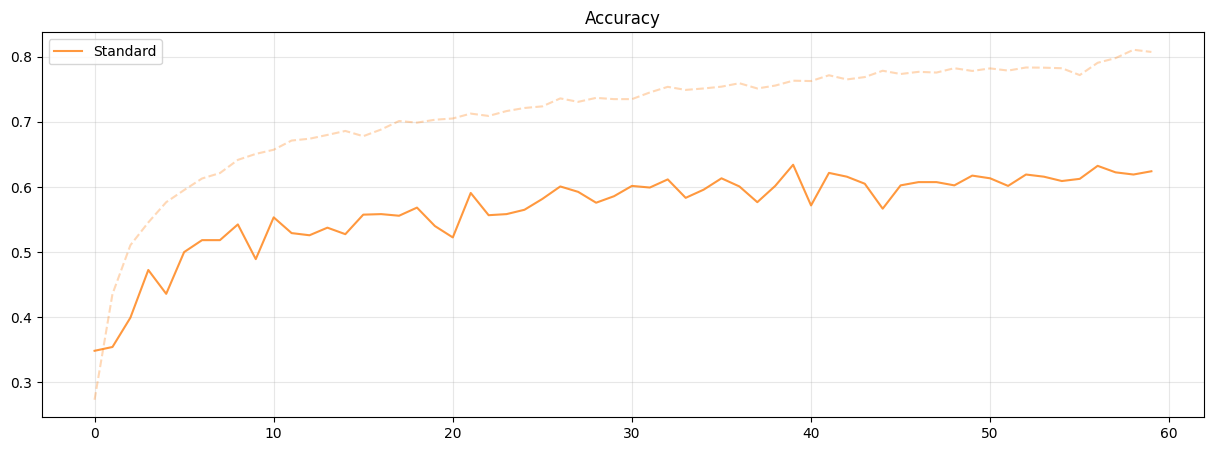

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Make Inference

In [ ]:
predictions = canonical_cnn.predict(X_test, verbose=0)

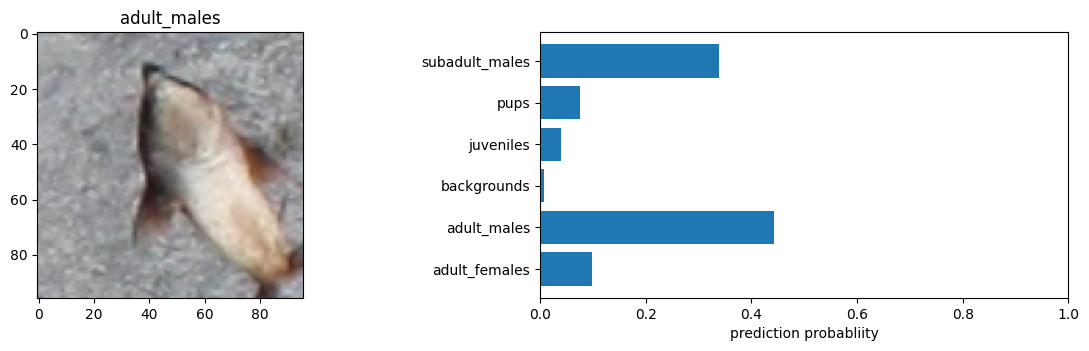

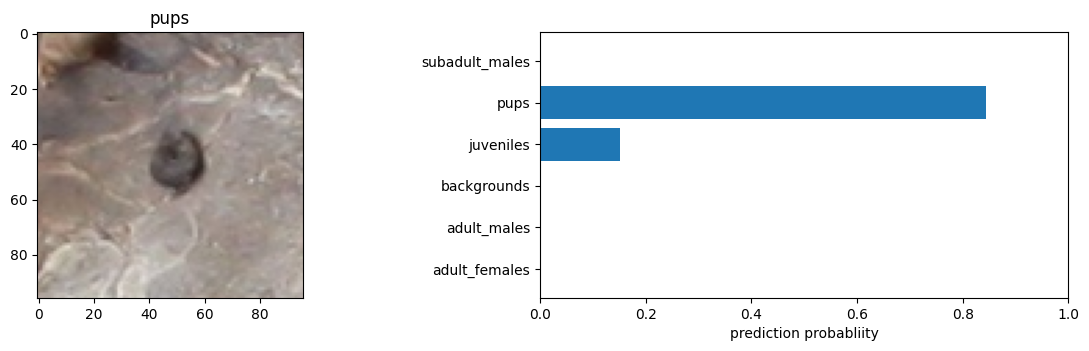

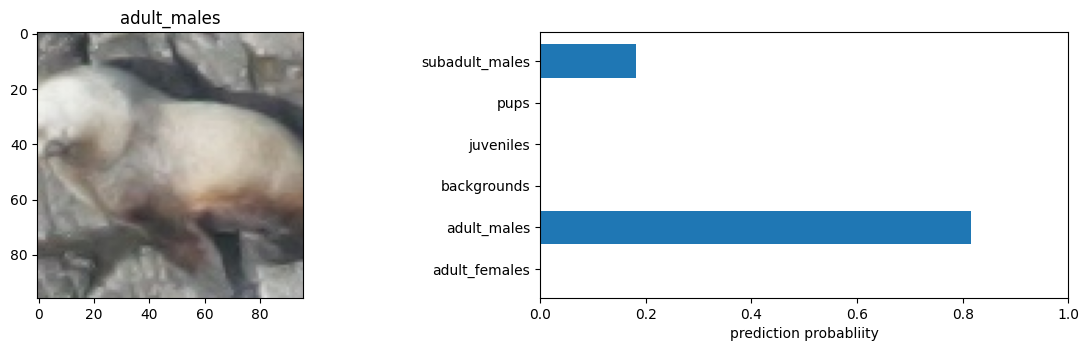

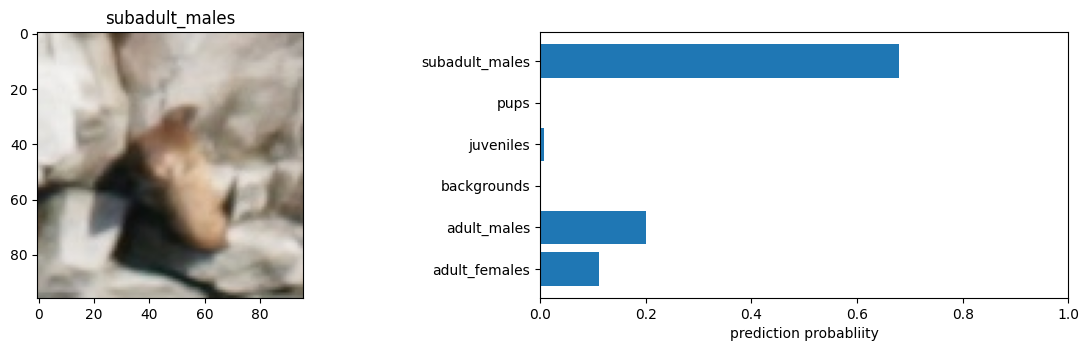

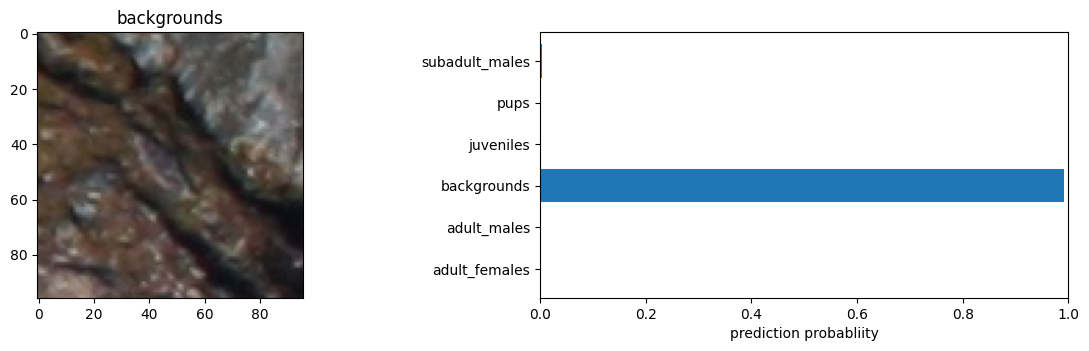

In [ ]:
for i in range(5):
    idx = np.random.randint(len(X_test))
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(X_test[idx])
    plt.title(classes[np.argmax(y_test,axis=-1)[idx]])
    plt.subplot(5, 2, 2*i+2)
    singlge_pred = predictions[idx]
    plt.barh(np.arange(6), singlge_pred)
    plt.yticks(np.arange(6), classes)
    plt.xlabel('prediction probabliity')
    plt.xlim(0,1)

Accuracy: 0.5742
Precision: 0.541
Recall: 0.5742
F1: 0.5504


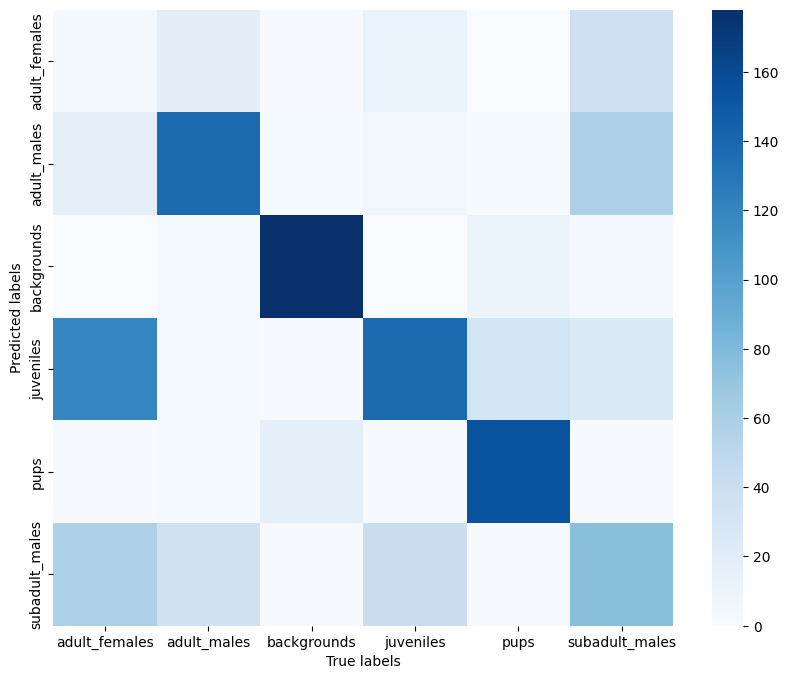

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### To Fully Convolutional CNN

In [ ]:
fc_input_shape = (None,None,3)
fc_output_shape = (None,None,output_shape)
print(fc_input_shape,fc_output_shape)

(None, None, 3) (None, None, 6)


In [ ]:
def build_fc_cnn(input_shape, output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(),
        tfkl.RandomRotation(0.125)
    ], name='preprocessing')

    x = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='conv1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv4')(x)

    """Remove the flatten layer"""
    # x = tfkl.Flatten(name='flatten')(x)

    """Dropout will not be used as we are not going to retrain the model"""
    # x = tfkl.Dropout(0.5)(x)

    """The number of parameters must be the same between dense and conv2d"""
    # x = tfkl.Dense(units=256, activation='relu', name='dense')(x)

    """Dropout will not be used as we are not going to retrain the model"""
    # x = tfkl.Dropout(0.5)(x)

    fully_conv = tfkl.Conv2D(filters=256, kernel_size=12, padding='valid',activation='relu',name='fully_conv_1')(x)

    """The number of parameters must be the same between dense and conv2d"""
    # output_layer = tfkl.Dense(units=output_shape, activation='softmax', name='Output')(x)

    output_layer = tfkl.Conv2D(filters=output_shape[-1], kernel_size=1, padding='valid', activation='softmax',name='fully_conv_2')(fully_conv)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CanonicalCNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

    # Return the model
    return model

fc_cnn = build_fc_cnn(fc_input_shape,fc_output_shape)
fc_cnn.summary()

Model: "CanonicalCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, None, 3)]   0         
                                                                 
 preprocessing (Sequential)  (None, None, None, 3)     0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    896       
                                                                 
 mp1 (MaxPooling2D)          (None, None, None, 32)    0         
                                                                 
 conv2 (Conv2D)              (None, None, None, 64)    18496     
                                                                 
 mp2 (MaxPooling2D)          (None, None, None, 64)    0         
                                                                 
 conv3 (Conv2D)              (None, None, None, 128)  

In [ ]:
canonical_cnn = tfk.models.load_model('canonical_cnn')
canonical_cnn.summary()

Model: "CanonicalCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 24, 24, 128)      

In [ ]:
# weight mapping, first 9 layers are the same
for i in range(9):
    canonical_weights = canonical_cnn.layers[i].get_weights()
    fc_cnn.layers[i].set_weights(canonical_weights)

w_second_last, b_second_last = canonical_cnn.layers[-3].get_weights()[0], canonical_cnn.layers[-3].get_weights()[1]
w_last, b_last = canonical_cnn.layers[-1].get_weights()[0], canonical_cnn.layers[-1].get_weights()[1]

# height_prev, width_prev, channels_prev, channels_out
canonical_weights_second_last = [w_second_last.reshape(12, 12, 256, 256), b_second_last]
fc_cnn.layers[-2].set_weights(canonical_weights_second_last)

canonical_weights_last = [w_last.reshape(1, 1, 256, 6), b_last]
fc_cnn.layers[-1].set_weights(canonical_weights_last)

In [ ]:
# check if the weights are mapping correctly
img = np.expand_dims(X_train[0],axis=0)
pred_canonical = canonical_cnn.predict(img, verbose=0)
print(pred_canonical.shape, pred_canonical)
pred_fc = fc_cnn.predict(img, verbose=0)
print(pred_fc.shape, pred_fc)

(1, 6) [[9.3321562e-01 7.8483596e-03 1.2495260e-04 5.2040685e-02 7.6852921e-05
  6.6935341e-03]]
(1, 1, 1, 6) [[[[9.3321550e-01 7.8483662e-03 1.2495283e-04 5.2040726e-02
    7.6852986e-05 6.6935392e-03]]]]


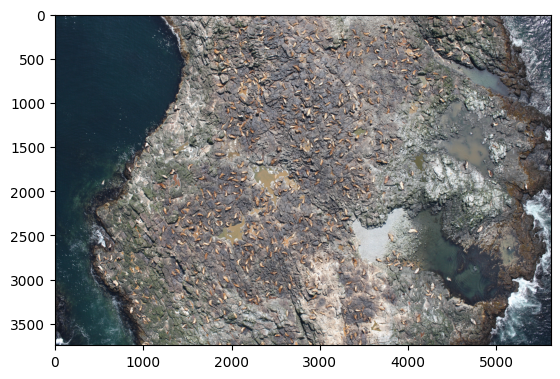

In [ ]:
# heatmaps
img = cv2.cvtColor(cv2.imread('wide_images/0.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
img_batch = np.expand_dims(img,axis=0)

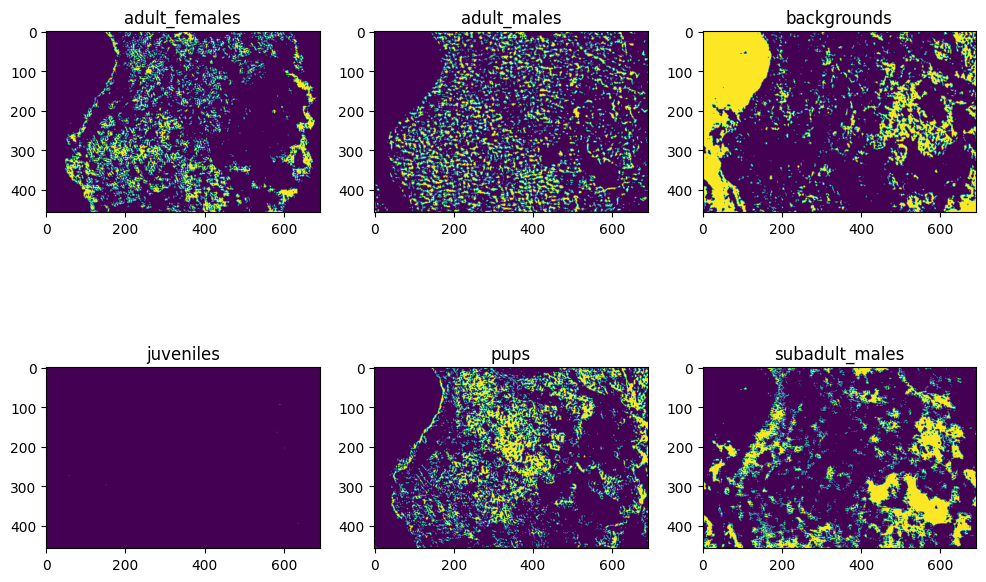

In [ ]:
heatmaps = fc_cnn.predict(img_batch,verbose=0)
plt.figure(figsize=(12, 8))
for i in range(6):
    heatmap = heatmaps[:, :, :, i][0]
    plt.subplot(2, 3, i+1)
    plt.imshow(heatmap)
    plt.title(classes[i])

In [ ]:
print('Big image shape', img_batch.shape)
print('Theoretical output shape', (1, img_batch.shape[1] // 8 - 11, img_batch.shape[2] // 8  - 11, 6))
print('Output shape', heatmaps.shape)

Big image shape (1, 3744, 5616, 3)
Theoretical output shape (1, 457, 691, 6)
Output shape (1, 457, 691, 6)


*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*